# Evaluate Equivalence between RBAs with different number of edges

## Evaluate the collected indicators

### Load the experiments

In [16]:
from classes.utils.customtext import CustomText
import pandas as pd

exp_path = "outputs/exp7_data_7_8_100/"
indicators_file = exp_path + 'data.csv'

df = pd.read_csv(indicators_file)
print("Archivo cargado exitosamente")

Archivo cargado exitosamente


In [17]:
num_registers = df.shape[0]
print(f"El DataFrame tiene {num_registers} registros.")
df.keys()

El DataFrame tiene 900 registros.


Index(['i_sample', 'n_local_networks', 'n_var_network', 'v_topology',
       'n_output_variables', 'n_clauses_function', 'n_edges',
       'n_local_attractors', 'n_pair_attractors', 'n_attractor_fields',
       'n_time_find_attractors', 'n_time_find_pairs', 'n_time_find_fields'],
      dtype='object')

## Filter by local network = 8

In [18]:
# filter by the number of local network
n_local_networks = 8
df_filter = df[df['n_local_networks'] == n_local_networks]
num_registers = df_filter.shape[0]
print(f"Existe {num_registers} registros para las RBAs de {n_local_networks} redes locales.")

Existe 500 registros para las RBAs de 8 redes locales.


### Find the sample with more number of Stable Attractor Fields

In [20]:
# Encontrar el índice del valor máximo de 'n_attractor_fields' y obtener 'i_sample' y 'Number of Edges'
max_sample = df_filter.loc[df_filter['n_attractor_fields'].idxmax(), ['i_sample', 'n_edges']]

# Asignar los valores de la muestra y el número de aristas
i_sample_max = max_sample['i_sample']
n_edges_max = max_sample['n_edges']

# Imprimir el resultado
print(f"The sample with more attractor fields is {i_sample_max} with number of edges {n_edges_max}")

The sample with more attractor fields is 84.0 with number of edges 12.0


### Load the CBN objects for an specific sample

In [6]:
import pickle
import os
import matplotlib.pyplot as plt

# Define el segundo número en la ruta del archivo pickle
i_sample = i_sample_max

# Ruta base sin el número cambiante
base_path_cbn = f'{exp_path}/pkl_cbn/cbn_{i_sample}_{n_local_networks}_'

# Número inicial y rango máximo
start_number = n_local_networks
max_number = 2 * start_number

# Lista de archivos pickle existentes
pickle_files = [f"{base_path_cbn}{i}.pkl" for i in range(start_number, max_number + 1) if os.path.exists(f"{base_path_cbn}{i}.pkl")]

l_o_cbn = []
# Iterador para cargar y mostrar las topologías
for path_cbn in pickle_files:
    with open(path_cbn, 'rb') as file:
        o_cbn = pickle.load(file)
        l_o_cbn.append(o_cbn)
print('CBN objects loads in l_o_cbn')

CBN objects loads in l_o_cbn


### Stable attractor fields for every Global Scene from specific sample 

In [7]:
import pandas as pd
from classes.utils.customtext import CustomText

# Inicializar listas para los datos
data = {
    "Sample": [],
    "Number of Local Networks": [],
    "Number of Edges": [],
    "Global Scene": [],
    "Attractor Fields Count": []
}

# Personaliza el título y los encabezados
CustomText.make_title(f" Number of Local Networks: {n_local_networks}, Sample: {i_sample}")

# Bucle para recorrer los objetos l_o_cbn
for o_cbn in l_o_cbn:
    num_edges = len(o_cbn.l_directed_edges)
    attractor_fields = o_cbn.get_n_attractor_fields()
    dict_global_scenes = o_cbn.count_fields_by_global_scenes()

    # Verificar si global_scenes no es None
    if dict_global_scenes:
        # Recorrer los diccionarios global_scenes
        for scene, count in dict_global_scenes.items():
            # Agregar datos al diccionario
            data["Sample"].append(i_sample)
            data["Number of Local Networks"].append(n_local_networks)
            data["Number of Edges"].append(num_edges)
            data["Global Scene"].append(scene)
            data["Attractor Fields Count"].append(count)

# Crear DataFrame
df_resumo = pd.DataFrame(data)
df_resumo

**************************************************
SAMPLE: 84, NUMBER OF LOCAL NETWORKS: 8
**************************************************
COUNTING THE STABLE ATTRACTOR FIELDS BY GLOBAL SCENE
COUNTING THE STABLE ATTRACTOR FIELDS BY GLOBAL SCENE
COUNTING THE STABLE ATTRACTOR FIELDS BY GLOBAL SCENE
COUNTING THE STABLE ATTRACTOR FIELDS BY GLOBAL SCENE
COUNTING THE STABLE ATTRACTOR FIELDS BY GLOBAL SCENE


,Sample,Number of Local Networks,Number of Edges,Global Scene,Attractor Fields Count
0,84,8,8,11111111,1048576
1,84,8,8,11110011,262144
2,84,8,8,00000000,65536
3,84,8,9,111111111,1048576
4,84,8,9,111100111,262144
5,84,8,9,000000000,65536
6,84,8,10,1111001110,262144
7,84,8,10,1111111110,524288
8,84,8,10,1111111111,524288
9,84,8,10,0000000000,65536


### Count the number attractor fields by edge

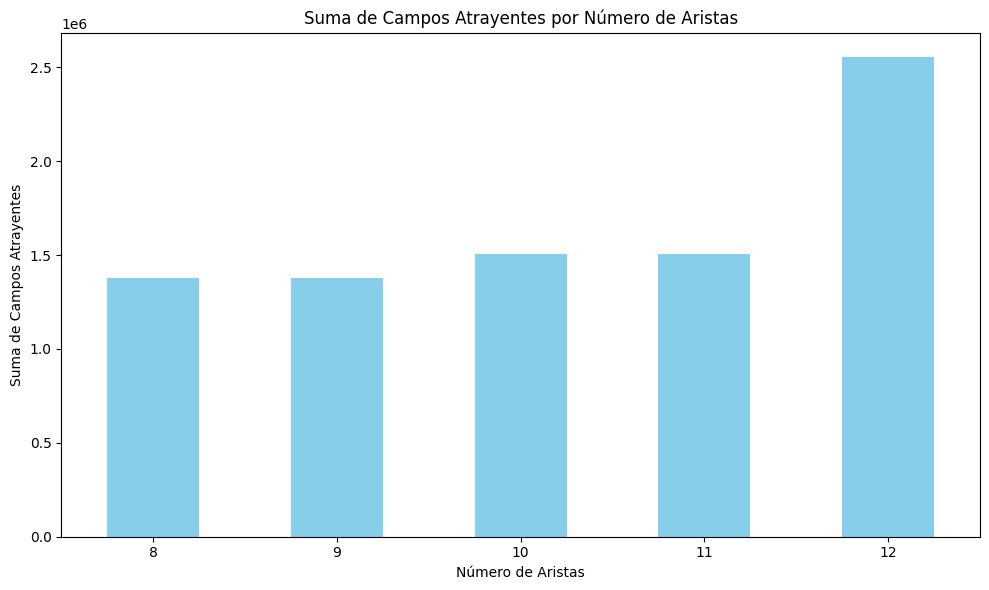

In [14]:
import matplotlib.pyplot as plt

# Agrupar por 'Number of Edges' y sumar la columna 'Attractor Fields Count'
df_suma_attractores = df_resumo.groupby('Number of Edges')['Attractor Fields Count'].sum()

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
df_suma_attractores.plot(kind='bar', color='skyblue')

# Configuración del gráfico
plt.title('Suma de Campos Atrayentes por Número de Aristas')
plt.xlabel('Número de Aristas')
plt.ylabel('Suma de Campos Atrayentes')
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar gráfico
plt.show()


### Count he number of global scenes by edge

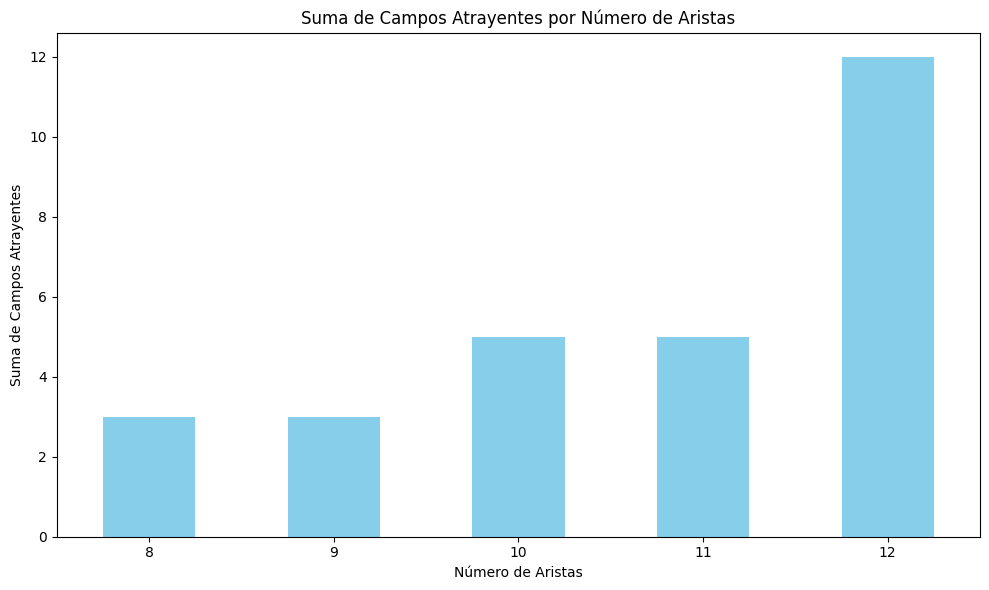

In [22]:
import matplotlib.pyplot as plt

# Agrupar por 'Number of Edges' y sumar la columna 'Attractor Fields Count'
df_suma_attractores = df_resumo.groupby('Number of Edges')['Global Scene'].count()

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
df_suma_attractores.plot(kind='bar', color='skyblue')

# Configuración del gráfico
plt.title('Suma de Campos Atrayentes por Número de Aristas')
plt.xlabel('Número de Aristas')
plt.ylabel('Suma de Campos Atrayentes')
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar gráfico
plt.show()

### Evaluate the number of stable attractor field by number of edges

In [9]:
target_network = 8 
df_filter = df[df['n_local_networks']==8]
df_filter

# 

,i_sample,n_local_networks,n_var_network,v_topology,n_output_variables,n_clauses_function,n_edges,n_local_attractors,n_pair_attractors,n_attractor_fields,n_time_find_attractors,n_time_find_pairs,n_time_find_fields
4,1,8,5,2,2,2,8,24,22,1,0.621660,0.000269,0.000695
5,1,8,5,2,2,2,9,26,30,1,0.647386,0.000309,0.000855
6,1,8,5,2,2,2,10,28,49,1,0.688651,0.000329,0.002005
7,1,8,5,2,2,2,11,30,65,1,0.992813,0.000429,0.004161
8,1,8,5,2,2,2,12,32,78,1,1.175072,0.000532,0.010013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,100,8,5,2,2,2,8,37,72,1296,1.430292,0.000413,0.057641
896,100,8,5,2,2,2,9,43,130,864,1.640043,0.000316,0.302549
897,100,8,5,2,2,2,10,44,142,865,1.675290,0.000353,0.293055
898,100,8,5,2,2,2,11,50,167,865,1.923635,0.000370,0.466898
